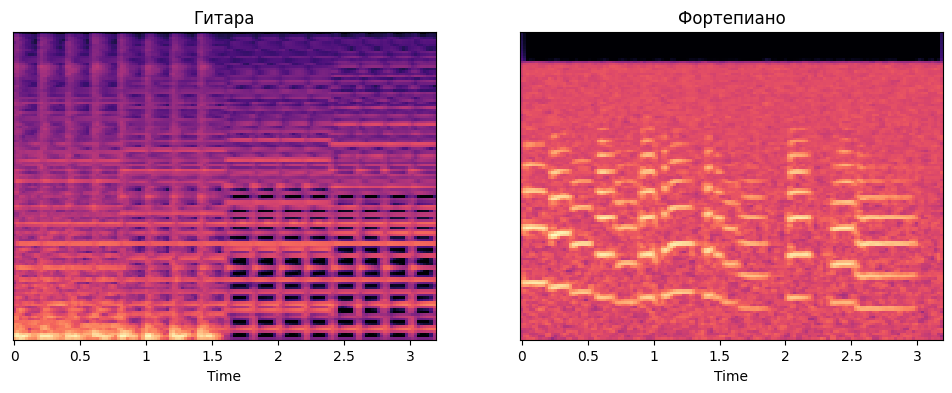

In [4]:
import torch
import torchaudio
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
# Загрузка аудио (гитара и фортепиано)
guitar, sr = librosa.load("/content/sample-3s (1).wav", sr=22050)
piano, _ = librosa.load("/content/noisy.wav", sr=22050)

# Обрежем до одинаковой длины
min_len = min(len(guitar), len(piano))
guitar = guitar[:min_len]
piano = piano[:min_len]

# Вычислим спектрограммы
def get_mel(audio, sr=22050, n_mels=128):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    return librosa.power_to_db(mel, ref=np.max)

guitar_mel = get_mel(guitar)
piano_mel = get_mel(piano)

# Визуализация
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
librosa.display.specshow(guitar_mel, sr=sr, x_axis='time')
plt.title('Гитара')
plt.subplot(1, 2, 2)
librosa.display.specshow(piano_mel, sr=sr, x_axis='time')
plt.title('Фортепиано')
plt.show()

In [5]:
class AudioTranslator(nn.Module):
    def __init__(self, n_mels=128):
        super().__init__()
        # Энкодер
        self.encoder = nn.Sequential(
            nn.Conv1d(n_mels, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 32, kernel_size=3, padding=1)
        )
        # Декодер
        self.decoder = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, n_mels, kernel_size=5, padding=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = AudioTranslator()

In [6]:
# Преобразуем данные в тензоры
guitar_tensor = torch.FloatTensor(guitar_mel).unsqueeze(0)
piano_tensor = torch.FloatTensor(piano_mel).unsqueeze(0)

# Loss и оптимизатор
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Обучение
for epoch in range(100):
    optimizer.zero_grad()
    output = model(guitar_tensor)
    loss = criterion(output, piano_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

Epoch 0, Loss: 1430.2305
Epoch 10, Loss: 127.1556
Epoch 20, Loss: 51.3360
Epoch 30, Loss: 37.3271
Epoch 40, Loss: 32.3214
Epoch 50, Loss: 29.2951
Epoch 60, Loss: 26.8748
Epoch 70, Loss: 25.0690
Epoch 80, Loss: 23.6394
Epoch 90, Loss: 22.5238


In [7]:
# Применяем модель
with torch.no_grad():
    translated_mel = model(guitar_tensor).squeeze().numpy()

# Обратное преобразование в аудио (используем Griffin-Lim)
translated_audio = librosa.griffinlim(
    librosa.db_to_power(translated_mel),
    n_iter=32,
    hop_length=512
)

# Сохранение результата
sf.write('translated.wav', translated_audio, sr)

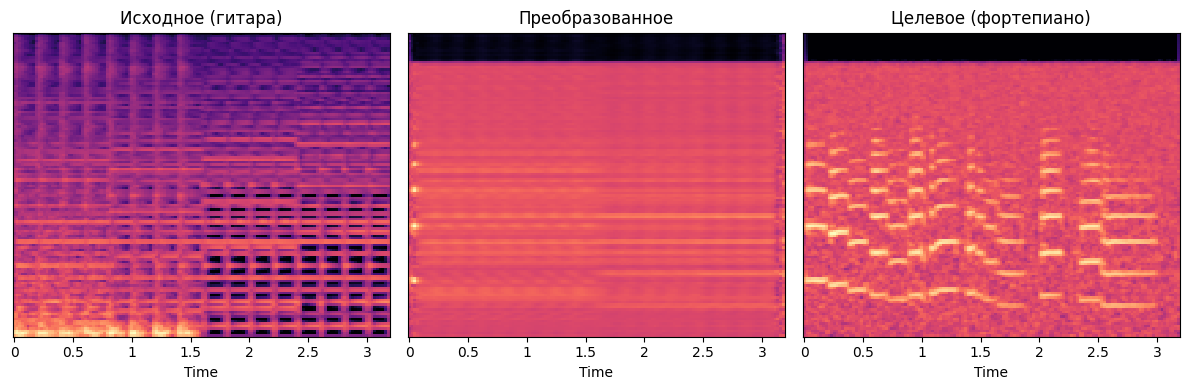

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
librosa.display.specshow(guitar_mel, sr=sr, x_axis='time')
plt.title('Исходное (гитара)')
plt.subplot(1, 3, 2)
librosa.display.specshow(translated_mel, sr=sr, x_axis='time')
plt.title('Преобразованное')
plt.subplot(1, 3, 3)
librosa.display.specshow(piano_mel, sr=sr, x_axis='time')
plt.title('Целевое (фортепиано)')
plt.tight_layout()
plt.show()